In [1]:
%matplotlib notebook

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

import lightgbm as lgb
from lightgbm.sklearn import LGBMRegressor

from xgboost import XGBRegressor, plot_importance

from sklearn.linear_model import Ridge, LassoCV, HuberRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from mlxtend.regressor import StackingCVRegressor

import seaborn as sns

/opt/homebrew/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Processing cols 8:16.

In [22]:
df_train = pd.read_csv('../input/cs5228-2021-semester-2-final-project/train.csv')
df_train[df_train.columns[8:16]].head()

,bathrooms,district,region,planning_area,subszone,lat,lng,tenure
0,2.0,10,central region,bukit timah,farrer court,1.313566,103.803218,freehold
1,2.0,15,central region,kallang,tanjong rhu,1.298437,103.884408,freehold
2,1.0,15,east region,bedok,frankel,1.317851,103.908905,freehold
3,1.0,17,east region,pasir ris,flora drive,1.358005,103.965725,leasehold/99 years
4,6.0,1,central region,downtown core,cecil,1.277474,103.849419,leasehold/99 years


In [23]:
# df_train['bathrooms'] = df_train['bathrooms'].fillna(0).astype(np.int64)
# df_train['bathrooms'].unique()
def processTenure(df_train):
    def repl(m):
        years = ''
        types = ''
        if 'years from' in m:
            duration = int(m.split(' years from ')[0])
            date = int(m.split('/')[2])
            years = str(duration - (2022 - date))
            types = 'leasehold'
        elif 'years' in m:
            if '/' in m:
                years = m.split('/')[1].split(' ')[0]
                types = 'leasehold'
            else:
                years = m.split(' ')[0]
                types = 'leasehold'
        if 'freehold' in m:
            types = 'freehold'

        if years != '' and int(years) >= 500:
            types = 'freehold'
            years = ''
        return years + ' ' + types

    df_train['tenure'] = df_train['tenure'].fillna('').apply(repl)
    df_train['tenure_year'] = df_train['tenure'].str.split(' ').str[0]
    df_train['tenure_year'] = pd.to_numeric(df_train['tenure_year'], errors = 'coerce')
    
    df_train['tenure_type'] = df_train['tenure'].str.split(' ').str[1]
    mapping = {k: v for v, k in enumerate(df_train['tenure_type'].unique())}
    print(mapping)
    df_train['tenure_type'] = df_train['tenure_type'].map(mapping)
    
processTenure(df_train)

{'freehold': 0, 'leasehold': 1, '': 2}


In [24]:
def processRegion(df_train):
    mapping = {k: v for v, k in enumerate(df_train['region'].unique())}
    print(mapping)
    df_train['region'] = df_train['region'].map(mapping)
processRegion(df_train)

{'central region': 0, 'east region': 1, 'west region': 2, 'north-east region': 3, 'north region': 4}


In [25]:
# df_train['region'].unique()
# df_train['tenure_year'].unique()
# df_train['tenure_type'].unique()
# df_train[df_train.columns[23:]].head()
df_train[df_train.columns[8:16]].head()

,bathrooms,district,region,planning_area,subszone,lat,lng,tenure
0,2.0,10,0,bukit timah,farrer court,1.313566,103.803218,freehold
1,2.0,15,0,kallang,tanjong rhu,1.298437,103.884408,freehold
2,1.0,15,1,bedok,frankel,1.317851,103.908905,freehold
3,1.0,17,1,pasir ris,flora drive,1.358005,103.965725,99 leasehold
4,6.0,1,0,downtown core,cecil,1.277474,103.849419,99 leasehold


# Processing cols 17:22

In [26]:
df_train[df_train.columns[16:23]].head()

,built_year,no_of_units,area_size,eco_category,accessibility,date_listed,tenure_year
0,NaN,638.0,710.0,uncategorized,guarded,2021-12-12,NaN
1,2016.0,130.0,1055.0,uncategorized,guarded,2021-10-12,NaN
2,2013.0,157.0,463.0,uncategorized,guarded,2021-12-23,NaN
3,1930.0,428.0,645.0,uncategorized,guarded,2021-12-31,99.0
4,NaN,NaN,6200.0,uncategorized,guarded,2021-07-14,99.0


In [27]:
# If built_year is a NAN, we replace it with the mean built_year of other houses 
# in order not to make this feature appear too prominent.
# As people may prefer newer houses, we treat 'built_year' as an integer.
df_train['built_year_till_now'] = df_train['built_year'].fillna(df_train['built_year'].mean()).astype(np.int64).apply(lambda x : 2022-x)
df_train['no_of_units'] = df_train['no_of_units'].fillna(df_train['no_of_units'].mean()).astype(np.int64)

In [28]:
# As data in the columns 'eco_category' and 'accessibility' are all the same,we delete them.
df_train = df_train.drop(columns=['eco_category', 'accessibility'])

In [29]:
# The sales date of a house can affect sales prices as well.
df_train['date_listed'] = pd.to_datetime(df_train['date_listed'])
df_train['date_listed_max'] = df_train['date_listed'].max()
df_train['date_listed_interval'] = (df_train['date_listed_max'] - df_train['date_listed']).map(lambda x : x.days)

In [30]:
# partition sales date into quarters.
df_train['date_listed_as_quarter'] = df_train['date_listed'].dt.to_period('Q')
df_train['date_listed_year'] = pd.to_numeric(df_train['date_listed_as_quarter'].astype(str).str.slice(0,4), errors = 'coerce')
df_train['date_listed_quarter'] = pd.to_numeric(df_train['date_listed_as_quarter'].astype(str).str.slice(5), errors = 'coerce')

In [31]:
df_train[df_train.columns[16:]].head()

,built_year,no_of_units,area_size,date_listed,tenure_year,tenure_type,built_year_till_now,date_listed_max,date_listed_interval,date_listed_as_quarter,date_listed_year,date_listed_quarter
0,NaN,638,710.0,2021-12-12,NaN,0,12,2022-01-06,25,2021Q4,2021,4
1,2016.0,130,1055.0,2021-10-12,NaN,0,6,2022-01-06,86,2021Q4,2021,4
2,2013.0,157,463.0,2021-12-23,NaN,0,9,2022-01-06,14,2021Q4,2021,4
3,1930.0,428,645.0,2021-12-31,99.0,1,92,2022-01-06,6,2021Q4,2021,4
4,NaN,453,6200.0,2021-07-14,99.0,1,12,2022-01-06,176,2021Q3,2021,3


# Processing cols 0:8.

In [48]:
%config Completer.use_jedi = False # autocompletion

In [60]:
df_train[df_train.columns[0:8]].head()

,Unnamed: 0,listing_id,name,street,type,model,market_segment,type_of_area
0,0,1487111,leedon green,leedon heights,condominium,condominium,ocr,strata
1,1,6794066,the line @ tanjong rhu,tanjong rhu road,condominium,condominium,ocr,strata
2,2,4027017,parc elegance,telok kurau road,apartment,apartment,ocr,strata
3,3,1119141,the jovell,13 flora drive,condominium,condominium,ocr,strata
4,4,7374262,shenton way,5 shenton way,condominium,condominium,ocr,strata


In [62]:
# now we would like to process building types and models
# we would first normalise them, and then encode
def processTypeModel(df):
    # encode building type
    mapping = {k: v for v, k in enumerate(df['type'].unique())}
    print(mapping)
    df['type'] = df['type'].map(mapping)
    
    # encode building model, need to normalise first
    def repl(m):
        if 'condominium' in m:
            return 'condominium'
        elif 'apartment' in m:
            return 'apartment'
        else:
            return 'unkown'
    df['model'] = df['model'].fillna('').apply(repl)
    mapping = {k: v for v, k in enumerate(df['model'].unique())}
    print(mapping)
    df['model'] = df['model'].map(mapping)
    
    return df

df_train = processTypeModel(df_train)

{'condominium': 0, 'apartment': 1}
{'condominium': 0, 'apartment': 1, 'unkown': 2}


In [73]:
df_train.head()

,Unnamed: 0,listing_id,name,street,type,model,market_segment,type_of_area,bedrooms,bathrooms,...,date_listed,tenure_year,tenure_type,built_year_till_now,date_listed_max,date_listed_interval,date_listed_as_quarter,date_listed_year,date_listed_quarter,minor_bedrooms
0,0,1487111,leedon green,leedon heights,0,0,ocr,strata,2,2.0,...,2021-12-12,NaN,0,12,2022-01-06,25,2021Q4,2021,4,0
1,1,6794066,the line @ tanjong rhu,tanjong rhu road,0,0,ocr,strata,3,2.0,...,2021-10-12,NaN,0,6,2022-01-06,86,2021Q4,2021,4,0
2,2,4027017,parc elegance,telok kurau road,1,1,ocr,strata,0,1.0,...,2021-12-23,NaN,0,9,2022-01-06,14,2021Q4,2021,4,0
3,3,1119141,the jovell,13 flora drive,0,0,ocr,strata,2,1.0,...,2021-12-31,99.0,1,92,2022-01-06,6,2021Q4,2021,4,0
4,4,7374262,shenton way,5 shenton way,0,0,ocr,strata,4,6.0,...,2021-07-14,99.0,1,12,2022-01-06,176,2021Q3,2021,3,0


In [72]:
# let's process bedroom numbers next.
# as we can observe, the bedroom sometimes has 'x+y' configs, this could be because one bedroom is for babies
# let's split bedroom up into two columns because of this.
def processBedrooms(df):
    df['bedrooms'] = df['bedrooms'].fillna(0)
    def splrm(m):
        tokens = str(m).split('+')
        if len(tokens) == 1 or tokens[1] == '':
            return pd.Series({'bedrooms': int(tokens[0]), 'minor_bedrooms': 0})
        else:
            return pd.Series({'bedrooms': int(tokens[0]), 'minor_bedrooms': int(tokens[1])})
    df[['bedrooms', 'minor_bedrooms']] = df.apply(lambda x : splrm(x['bedrooms']), axis=1)
    
    return df

#df_train['bedrooms'] = df_train['bedrooms'].astype(np.int64).fillna(df_train['bedrooms'].mean())
df_train = processBedrooms(df_train)

In [74]:
# let's finish preprocessing 0:8 with some more data cleaning
def cleanCols08(df):
    # since we have no use of columns id, name, street now, let's drop them
    df = df.drop(columns=['Unnamed: 0', 'listing_id', 'name', 'street'])
    
    # we can also observe that there are no variations in market segment and area tyoe
    # hence they are also dropped
    df = df.drop(columns=['market_segment', 'type_of_area'])
    
    return df

df_train = cleanCols08(df_train)

In [75]:
df_train.head()

,type,model,bedrooms,bathrooms,district,region,planning_area,subszone,lat,lng,...,date_listed,tenure_year,tenure_type,built_year_till_now,date_listed_max,date_listed_interval,date_listed_as_quarter,date_listed_year,date_listed_quarter,minor_bedrooms
0,0,0,2,2.0,10,0,bukit timah,farrer court,1.313566,103.803218,...,2021-12-12,NaN,0,12,2022-01-06,25,2021Q4,2021,4,0
1,0,0,3,2.0,15,0,kallang,tanjong rhu,1.298437,103.884408,...,2021-10-12,NaN,0,6,2022-01-06,86,2021Q4,2021,4,0
2,1,1,0,1.0,15,1,bedok,frankel,1.317851,103.908905,...,2021-12-23,NaN,0,9,2022-01-06,14,2021Q4,2021,4,0
3,0,0,2,1.0,17,1,pasir ris,flora drive,1.358005,103.965725,...,2021-12-31,99.0,1,92,2022-01-06,6,2021Q4,2021,4,0
4,0,0,4,6.0,1,0,downtown core,cecil,1.277474,103.849419,...,2021-07-14,99.0,1,12,2022-01-06,176,2021Q3,2021,3,0


In [78]:
# save the preprocessed data
df_train.to_csv('train_processed.csv',index=False)

# Machine Learning Regression Model

## Load Data

In [3]:
df_train = pd.read_csv("train_all_features.csv")
# df_train["tenure_year"] = df_train["tenure_year"].fillna(df_train["tenure_year"].mean())
# df_train["bathrooms"] = df_train["bathrooms"].fillna(df_train["bathrooms"].mean())
# df_train["area_size"] = df_train["area_size"].fillna(df_train["area_size"].mean())
# df_train.to_csv('train_all_features.csv',index=False)

In [4]:
df_X = df_train.iloc[:, :18]
df_y = df_train["price"]

In [5]:
df_X.head()

,type,model,bedrooms,minor_bedrooms,bathrooms,no_of_units,area_size,tenure_year,tenure_type,built_year_till_now,date_listed_interval,date_listed_year,date_listed_quarter,nearby_Starbucks,nearby_7-Eleven,nearby_Mcdonald,nearby_KFC,deep_spatial_0
0,0,0,3,0,4.0,151,2336.0,99.000000,0,11,247,2021,2,0,1,0,0,-1167.717163
1,1,1,3,0,3.0,24,1259.0,98.941416,1,23,244,2021,2,5,14,3,2,-536.514099
2,0,0,4,0,3.0,235,1959.0,98.941416,1,10,190,2021,2,4,17,3,2,-1205.774170
3,0,0,3,0,2.0,237,883.0,98.941416,1,12,4,2022,1,0,5,1,1,-339.450104
4,1,1,3,0,3.0,36,1066.0,98.941416,1,12,13,2021,4,3,9,2,1,-375.779877


In [6]:
df_X.columns

Index(['type', 'model', 'bedrooms', 'minor_bedrooms', 'bathrooms',
       'no_of_units', 'area_size', 'tenure_year', 'tenure_type',
       'built_year_till_now', 'date_listed_interval', 'date_listed_year',
       'date_listed_quarter', 'nearby_Starbucks', 'nearby_7-Eleven',
       'nearby_Mcdonald', 'nearby_KFC', 'deep_spatial_0'],
      dtype='object')

In [7]:
df_y.head()

0    5390000.0
1    2310000.0
2    5279500.0
3    1843600.0
4    2262700.0
Name: price, dtype: float64

In [8]:
num_samples, num_features = df_X.shape
print('The dataset contains {} samples with {} features.'
      .format(num_samples, num_features)
     )
print(df_y.shape)

The dataset contains 26048 samples with 18 features.
(26048,)


## Basic Model Evaluation

In [9]:
# Convert dataframes to numpy arrays
X, y = df_X.to_numpy(), df_y.to_numpy()
y = y.ravel().astype(int)

# Split dataset in training and test data (20% test data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
y_train = y_train
# Normalize data using the sciki-learn StandardScaler
scaler = preprocessing.StandardScaler().fit(X_train)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

print('Number of features: {}'.format(X_train.shape[1]))
print('Number of samples for training: {}'.format(X_train.shape[0]))
print('Number of samples for testing: {}'.format(X_test.shape[0]))

Number of features: 18
Number of samples for training: 20838
Number of samples for testing: 5210


In [10]:
%%time
rgs_rforest = RandomForestRegressor().fit(X_train, y_train)
rgs_dtree = DecisionTreeRegressor().fit(X_train, y_train)
rgs_adaboost = AdaBoostRegressor().fit(X_train, y_train)
rgs_gdboost = GradientBoostingRegressor().fit(X_train, y_train)

CPU times: user 9.35 s, sys: 43.5 ms, total: 9.39 s
Wall time: 9.39 s


In [11]:
%%time
print('Root Mean Squared Errors for all regressors')
print('============================')
rlist1 = []

for rgs in [rgs_dtree, rgs_rforest, rgs_gdboost]:
    try:
        # Predict for test samples
        y_pred = rgs.predict(X_test)
        # Calculate the root mean squared error and mean absolute error
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        rlist1.append(rmse)
    except Exception as e:
        print(e)
        # Handle exception (e.g., a classifier is still None)
        mae = '---'
        
    print('{} mae: {:.3} rmse: {:.3}'.format(type(rgs).__name__, mae, rmse))
    

Root Mean Squared Errors for all regressors
DecisionTreeRegressor mae: 2.28e+05 rmse: 6.42e+05
RandomForestRegressor mae: 1.92e+05 rmse: 4.82e+05
GradientBoostingRegressor mae: 3.08e+05 rmse: 5.88e+05
CPU times: user 138 ms, sys: 5.96 ms, total: 144 ms
Wall time: 141 ms


In [29]:
rlist1

[1712973.3214423256, 1241549.5977621162, 1358091.720799529]

In [35]:
rlist2

[968316.0819989459, 841140.223972918, 1087530.6179555347]

In [42]:
rlist3

[679827.652108055, 503122.74537300976, 594916.7203916563]

<IPython.core.display.Javascript object>


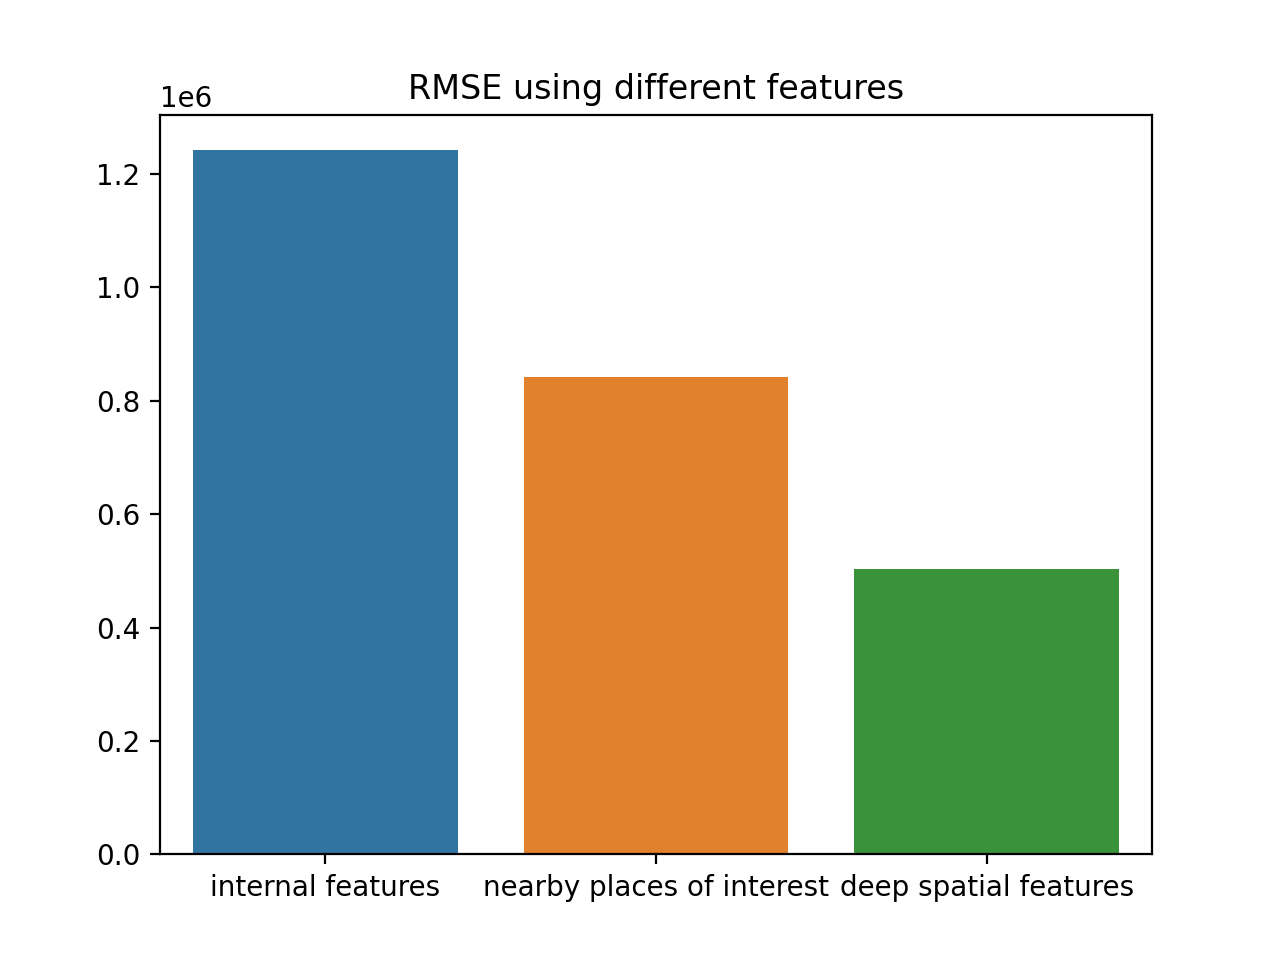

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'RMSE using different features')

In [12]:
plt.figure()
x = ["internal features", "nearby places of interest", "deep spatial features"]
y = [1241549.5977621162, 841140.223972918, 503122.74537300976]
sns.barplot(x, y)
plt.title("RMSE using different features")

In [21]:
%%time
X, y = df_X.to_numpy(), df_y.to_numpy()
y = y.ravel().astype(int)

# LightGBM
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)
my_imputer = SimpleImputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

lgbm = lgb.LGBMRegressor(objective='regression', learning_rate=0.05, n_estimators=1000)
lgbm.fit(train_X, train_y, verbose=False)

predictions = lgbm.predict(test_X)

rmse = np.sqrt(mean_squared_error(predictions, test_y))
print("Root Mean Squared Error : " + str(rmse))
#rlist.append(rmse)

/opt/homebrew/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Root Mean Squared Error : 572124.0996665264
CPU times: user 7.29 s, sys: 1.23 s, total: 8.52 s
Wall time: 1.18 s


[15:16:18] WARNING: /private/var/folders/1t/n1_2wl4d2cbcrb7mdrp6phrw0000gn/T/pip-install-2vgx1ax7/xgboost_54b79628083843f7ba7d8e946171c650/build/temp.macosx-12-arm64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




<IPython.core.display.Javascript object>


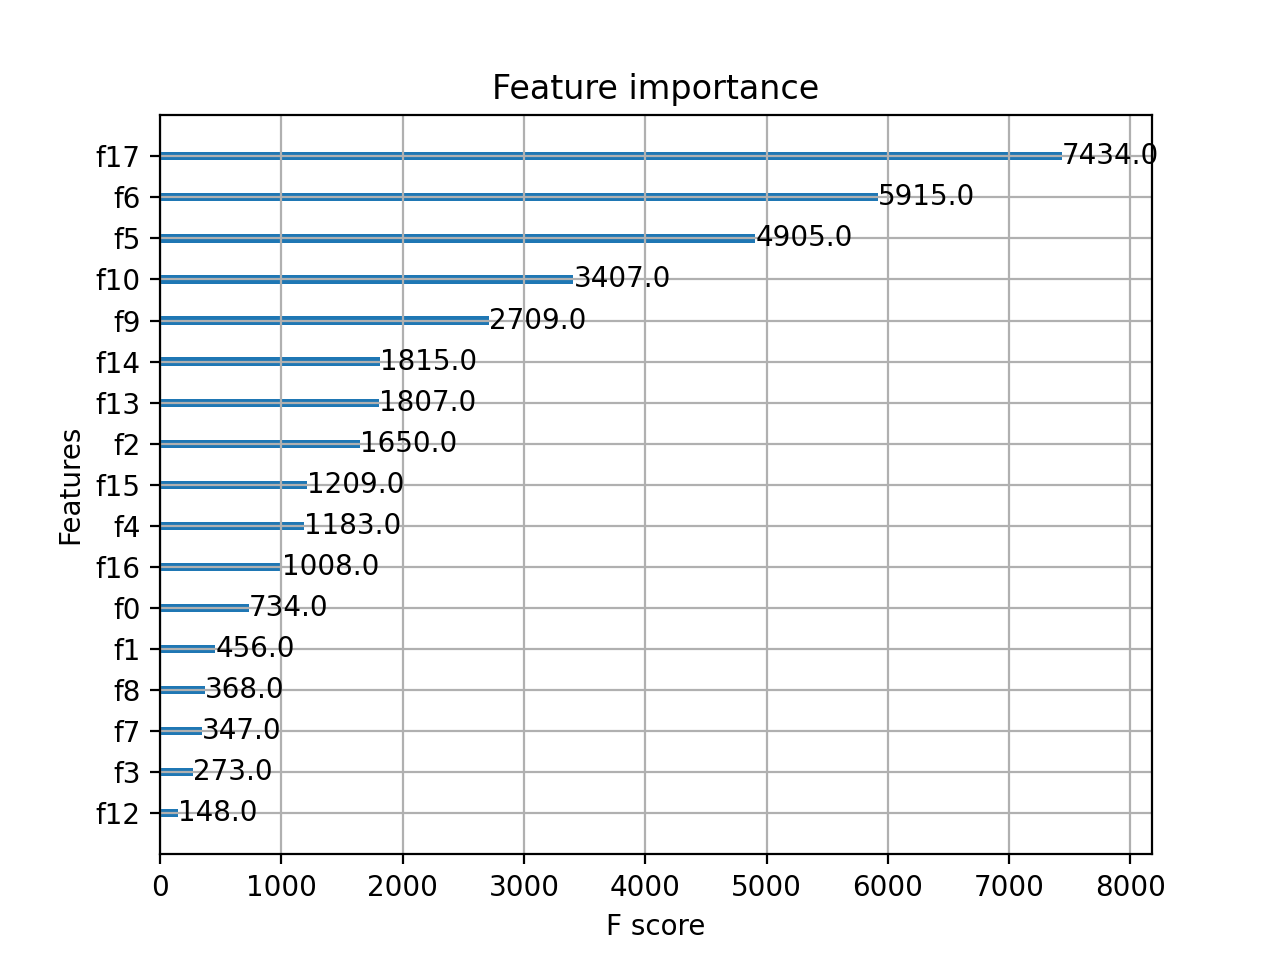

Root Mean Squared Error : 517669.1687151861
CPU times: user 34.7 s, sys: 6.08 s, total: 40.8 s
Wall time: 5.38 s


In [22]:
%%time

X, y = df_X.to_numpy(), df_y.to_numpy()
y = y.ravel().astype(int)

# XGBoost
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.2, random_state=0)
y1_train = y1_train

xgb = XGBRegressor(learning_rate=0.05, n_estimators=1000, silent=True, objective='reg:gamma')
xgb.fit(X1_train, y1_train)

y1_pred = xgb.predict(X1_test)

plot_importance(xgb)
plt.show()

rmse = np.sqrt(mean_squared_error(y1_pred, y1_test))
print("Root Mean Squared Error : " + str(rmse))
#rlist.append(rmse)

In [29]:
%%time

stackmodel = StackingCVRegressor(regressors=(rgs_dtree, rgs_rforest, rgs_gdboost, lgbm, xgb), meta_regressor=rgs_rforest, use_features_in_secondary=True)
rgs_stack = stackmodel.fit(X_train, y_train)
y_pred = rgs_stack.predict(X_test)

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print('{} mae: {:.3} rmse: {:.3}'.format(type(rgs_stack).__name__, mae, rmse))
# rlist.append(rmse)

[15:19:29] WARNING: /private/var/folders/1t/n1_2wl4d2cbcrb7mdrp6phrw0000gn/T/pip-install-2vgx1ax7/xgboost_54b79628083843f7ba7d8e946171c650/build/temp.macosx-12-arm64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:19:33] WARNING: /private/var/folders/1t/n1_2wl4d2cbcrb7mdrp6phrw0000gn/T/pip-install-2vgx1ax7/xgboost_54b79628083843f7ba7d8e946171c650/build/temp.macosx-12-arm64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you

<IPython.core.display.Javascript object>


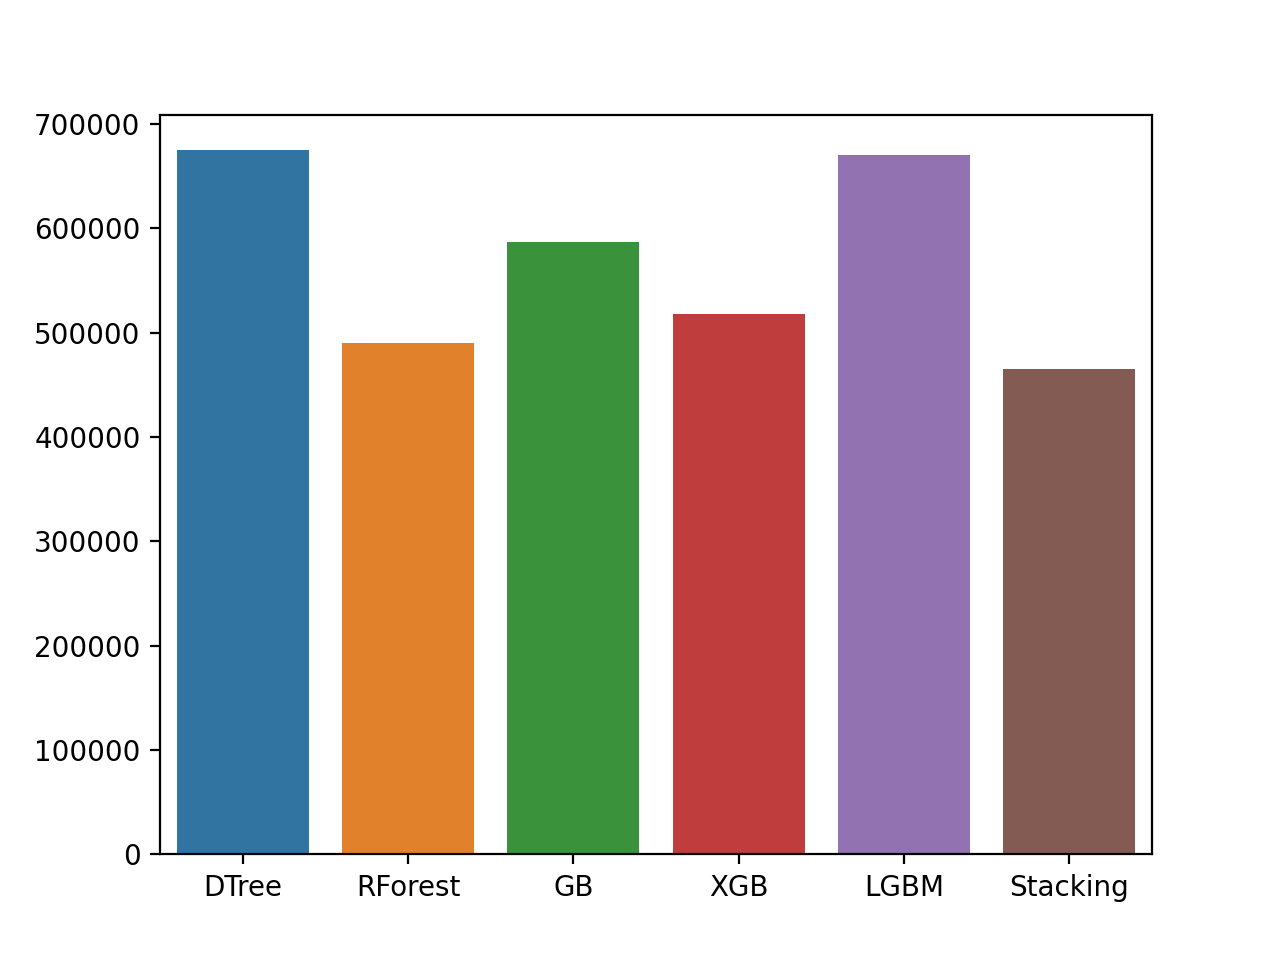

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

In [497]:
plt.figure()
x = ["DTree", "RForest", "GB", "XGB", "LGBM", "Stacking"]
y = rlist
sns.barplot(x, y)
plt.title("Distribution plot of "+metrics)

## Hyperparameter Tuning

In [46]:
%%time

model = None

param_grid = {
    'n_estimators': [20, 40, 100], 
    'max_depth': [3, 10, None],
    'max_features': [12, 18, 27], 
    'bootstrap': [True]
             }

rgs = RandomForestRegressor()
model = GridSearchCV(rgs, param_grid, cv=5,
                          scoring='neg_mean_squared_error')
model.fit(X_train, y_train)

# Store the parameters of the best model
best_params = model.best_params_

# Predict with test data on the model with the best found parameters
y_pred = model.predict(X_test)

# Calculate the root mean squared error
best_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('Best RandomForestRegressor: {} (RMSE: {:.3f})'.format(best_params, best_rmse))

/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/opt/homebrew/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/homebrew/lib/python3.9/site-packages/joblib

Best RandomForestRegressor: {'bootstrap': True, 'max_depth': None, 'max_features': 12, 'n_estimators': 40} (RMSE: 514296.026)
CPU times: user 2min 13s, sys: 1.08 s, total: 2min 14s
Wall time: 2min 15s


In [59]:
grid = GridSearchCV(estimator=stackmodel,
                    param_grid={'meta_regressor__n_estimators': [20, 40, 100]},
                    cv=5,
                    refit=True
)
 
grid.fit(X, y)

best_params = grid.best_params_
y_pred = grid.predict(X_test)

# Calculate the mean squared error
best_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#best_mae = mean_absolute_error(y_test, y_pred)

print('Best RandomForestRegressor: {} (RMSE: {:.3f})'.format(best_params, best_rmse))

[13:55:52] WARNING: /private/var/folders/1t/n1_2wl4d2cbcrb7mdrp6phrw0000gn/T/pip-install-2vgx1ax7/xgboost_54b79628083843f7ba7d8e946171c650/build/temp.macosx-12-arm64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:55:56] WARNING: /private/var/folders/1t/n1_2wl4d2cbcrb7mdrp6phrw0000gn/T/pip-install-2vgx1ax7/xgboost_54b79628083843f7ba7d8e946171c650/build/temp.macosx-12-arm64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you

[13:59:09] WARNING: /private/var/folders/1t/n1_2wl4d2cbcrb7mdrp6phrw0000gn/T/pip-install-2vgx1ax7/xgboost_54b79628083843f7ba7d8e946171c650/build/temp.macosx-12-arm64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:59:55] WARNING: /private/var/folders/1t/n1_2wl4d2cbcrb7mdrp6phrw0000gn/T/pip-install-2vgx1ax7/xgboost_54b79628083843f7ba7d8e946171c650/build/temp.macosx-12-arm64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you

[14:02:58] WARNING: /private/var/folders/1t/n1_2wl4d2cbcrb7mdrp6phrw0000gn/T/pip-install-2vgx1ax7/xgboost_54b79628083843f7ba7d8e946171c650/build/temp.macosx-12-arm64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:03:19] WARNING: /private/var/folders/1t/n1_2wl4d2cbcrb7mdrp6phrw0000gn/T/pip-install-2vgx1ax7/xgboost_54b79628083843f7ba7d8e946171c650/build/temp.macosx-12-arm64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you

[14:07:14] WARNING: /private/var/folders/1t/n1_2wl4d2cbcrb7mdrp6phrw0000gn/T/pip-install-2vgx1ax7/xgboost_54b79628083843f7ba7d8e946171c650/build/temp.macosx-12-arm64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:07:19] WARNING: /private/var/folders/1t/n1_2wl4d2cbcrb7mdrp6phrw0000gn/T/pip-install-2vgx1ax7/xgboost_54b79628083843f7ba7d8e946171c650/build/temp.macosx-12-arm64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you

[14:30:05] WARNING: /private/var/folders/1t/n1_2wl4d2cbcrb7mdrp6phrw0000gn/T/pip-install-2vgx1ax7/xgboost_54b79628083843f7ba7d8e946171c650/build/temp.macosx-12-arm64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:30:09] WARNING: /private/var/folders/1t/n1_2wl4d2cbcrb7mdrp6phrw0000gn/T/pip-install-2vgx1ax7/xgboost_54b79628083843f7ba7d8e946171c650/build/temp.macosx-12-arm64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you

[14:34:46] WARNING: /private/var/folders/1t/n1_2wl4d2cbcrb7mdrp6phrw0000gn/T/pip-install-2vgx1ax7/xgboost_54b79628083843f7ba7d8e946171c650/build/temp.macosx-12-arm64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:34:51] WARNING: /private/var/folders/1t/n1_2wl4d2cbcrb7mdrp6phrw0000gn/T/pip-install-2vgx1ax7/xgboost_54b79628083843f7ba7d8e946171c650/build/temp.macosx-12-arm64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you

## Prediction

In [37]:
df_test = pd.read_csv("test_all_features.csv")
# df_test = df_test.drop(columns=['Unnamed: 0', "predicted"])
# df_test.to_csv('test_all_features.csv',index=False)

In [38]:
df_test.head()

,type,model,bedrooms,minor_bedrooms,bathrooms,no_of_units,area_size,tenure_year,tenure_type,built_year_till_now,...,deep_spatial_0,deep_spatial_1,deep_spatial_2,deep_spatial_3,deep_spatial_4,deep_spatial_5,deep_spatial_6,deep_spatial_7,deep_spatial_8,deep_spatial_9
0,0,0,2,0,2.0,638,710.0,98.963252,0,12,...,-472.898010,-2033.779541,-7514.574707,-6497.932617,-5452.854492,-2177.035889,3283.280029,-8376.793945,-2316.123535,-1490.614868
1,0,0,3,0,2.0,130,1055.0,98.963252,0,6,...,-530.212463,-2369.505371,-8453.864258,-7312.494141,-6149.536621,-2422.780029,3764.130371,-9471.375977,-2630.946045,-1666.968628
2,1,1,0,0,1.0,157,463.0,98.963252,0,9,...,-329.287506,-1053.459106,-4954.382324,-4285.679688,-3541.206055,-1537.524292,1915.280762,-5357.370117,-1455.651367,-1024.747070
3,0,0,2,0,1.0,428,645.0,99.000000,1,92,...,-315.361725,-962.959595,-4673.562988,-4042.957275,-3334.200684,-1463.317017,1777.836182,-5035.754395,-1366.765625,-971.703186
4,0,0,4,0,6.0,453,6200.0,99.000000,1,12,...,-4938.482422,-21650.353516,-84005.820312,-73239.539062,-60309.457031,-24763.349609,36062.632812,-92631.007812,-26033.656250,-16706.031250


In [39]:
X_for_test = df_test.iloc[:, :18].to_numpy()

In [40]:
print('Number of features: {}'.format(X_for_test.shape[1]))
print('Number of samples for testing: {}'.format(X_for_test.shape[0]))

Number of features: 18
Number of samples for testing: 7500


In [36]:
# %%time
# rgs = rgs_rforest
# #rgs = model
# X_for_test = scaler.transform(X_for_test)
# y_pred = rgs.predict(X_for_test)
# #print("prediction ", y_pred)
# #print("test ", y_test)
# df_test["Predicted"] = pd.Series(y_pred)
# df_test["Predicted"].to_csv("test_predicted.csv")

CPU times: user 167 ms, sys: 3.96 ms, total: 171 ms
Wall time: 168 ms


In [42]:
%%time

rgs = rgs_stack
X_for_test = scaler.transform(X_for_test)
y_pred = rgs.predict(X_for_test)
#print("prediction ", y_pred)
#print("test ", y_test)
df_test["Predicted"] = pd.Series(y_pred)
df_test["Predicted"].to_csv("test_predicted.csv")

CPU times: user 1.76 s, sys: 387 ms, total: 2.14 s
Wall time: 417 ms
